# Portfolio exercises:
### 1. load and inspect the data 
- what are missing/problematic entries?

### 2. data exploration and cleaning 
- remove, fill, change data (if you think this makes sense or is necessary/beneficial)
- inspect two different types of labels (`label` and `infection_type`). How many classes are there and is there any bias? If so, is there anything we have to take care of?


### 3. Prepare data for machine learning: 
- Separate data / labels
- Split into train ~70% / validation ~15% / test ~15%

### 4. Build an image generator pipeline
- Use keras `ImageDataGenerator` to define a `train_generator` and a `validation_generator`.
- Use the generator to recale the pixel values and to reshape the image to the desired format.

### 5. Train your own custom-made CNN (pneumonia yes/no prediction)
- Define a conventional CNN image classifier (convolution-pooling steps, followed by dense layers) to predict if a patient has pneumonia or not.

### 6. Use transfer learning to train a CNN classifier (pneumonia yes/no prediction)
- Pick any suitable CNN you like (e.g. Resnet-50, Densenet, MobileNet...) and create your own image classifier from there.

### 7. Evaluate both models
- Evaluate the models on data other than the training data.
- Plot a ROC curve and compute the area under the curve (AUC). What does this tell you?
- Compare to your custom-made CNN: which one achieves better results (and why)? Which one trains faster (and why)? What would you prefer to use in an actual medical application?

### 8. Train a CNN for a multi-class prediction (bacteria, virus, none)
- Adapt a CNN (e.g. pick one form 5. or 6.) and modify it to predict if a patient has a bacterial or a virus infection, or none of both using the `infection_type` column as label.
- This requires to also adapt the generators.

### 9. Evaluate the multi-class model
- Evaluate the multi-class prediction model, simliar to what you did in (7.). Again also include a ROC curve (now of course for all 3 possible labels).
- Is the performance comparable, better, worse than the pneumonia/no pneumonia case?
- Which label can be predicted with the highest precision?

### 10. Possible improvements
Try two possible strategies to improve the results you got on 8. and 9.
- Data augmentation.
- Model fine tuning. This refers to the training of a large network with lower learning rate, but with more layers of the base model being set to `trainable`.
We haven't done this before, so here some example code of how to "unfreeze" some layers and make them trainable again:
```python
# Now: unfreeze some of the base model layers and do a second pass of training
for layer in model.layers[:100]:
    layer.trainable = False
for layer in model.layers[100:]:
    layer.trainable = True
``` 
You can still use the `Adam` optimizer, but preferably with a much lower learning rate, maybe `1e-5`.
- Do you see any promising effect of one or both of those strategies?


## Final submission:
Please address all the above mentioned points in this notebook (e.g., using text cells where needed for explanations or answers). Obviously, you can use code snippets from notebooks we have already worked on during the live coding sessions.


### Happy hacking!!!

In [65]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

## The Dataset

Similar to former notebooks where we worked with the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315), where here have a smaller X-ray dataset containing 5856 images.
Instead of 14 different diseases we will here concentrate on much fewer possible labels so that *hopefully* the number of images is enough to train good deep learning classifiers.

The images are distributed accross two folders (`NORMAL` and `PNEUMONIA`), the related metadata can be found in `x_ray_metadata_portfolio.csv` but actually also is reflected in the image file names.

## Import metadata

In [66]:
path_data = "data/ChestXray_pneumonia_prediction/"
filename = "x_ray_metadata_portfolio.csv"
metadata = pd.read_csv(os.path.join(path_data,filename))
metadata.head()

,patient_id,label,infection_type,folder,image
0,0001,normal,none,NORMAL,IM-0001-0001.jpeg
1,0003,normal,none,NORMAL,IM-0003-0001.jpeg
2,0005,normal,none,NORMAL,IM-0005-0001.jpeg
3,0006,normal,none,NORMAL,IM-0006-0001.jpeg
4,0007,normal,none,NORMAL,IM-0007-0001.jpeg


### 1. load and inspect the data 
- what are missing/problematic entries?


In [67]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   patient_id      5856 non-null   object
 1   label           5856 non-null   object
 2   infection_type  5856 non-null   object
 3   folder          5856 non-null   object
 4   image           5856 non-null   object
dtypes: object(5)
memory usage: 228.9+ KB


Auf den ersten Blick keine fehlenden Daten. Die Datentypen sind alles Objekte. Die Labels noch in numerische Form gebracht werden.

In [68]:
metadata.describe()

,patient_id,label,infection_type,folder,image
count,5856,5856,5856,5856,5856
unique,2790,2,3,2,5856
top,person23,pneumonia,bacteria,PNEUMONIA,IM-0001-0001.jpeg
freq,31,4273,2780,4273,1


Nur 2790 Patienten haben eine unique ID. Wir haben 5856 unique Bilder, die sich auf 2790 Patienten verteilen. Das heißt, dass es Patienten gibt, die mehrere Bilder im Datenset haben. Das ist problematisch da es zu Data Leakage führen kann. Später muss beim Aufteilen des Datensets darauf geachtet werden, dass die Bilder eines Patienten nicht in Train, Val- und Testset aufgeteilt werden.

In [69]:
metadata["patient_id"]

0           0001
1           0003
2           0005
3           0006
4           0007
          ...   
5851    person99
5852     person9
5853     person9
5854     person9
5855     person9
Name: patient_id, Length: 5856, dtype: object

Die Spalte Patienten ID hat kein konsistentes Format. Es gibt numerische Einträge sowie Einträge mit Buchstaben (Strings). Da die Spalte aber nicht für das Training verwendet wird, ist der Datentyp nicht weiter schlimm. 

In [70]:
metadata["patient_id"].value_counts()

person23      31
person124     20
person441     18
person30      15
person1320    14
              ..
person1580     1
0907           1
person1579     1
person1577     1
0001           1
Name: patient_id, Length: 2790, dtype: int64

Wie vermutet gibt es Patienten mit mehreren Bildern im Datenset.

In [71]:
mask = metadata["patient_id"] == "person23"
metadata[mask]

,patient_id,label,infection_type,folder,image
3494,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_100.jpeg
3495,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_101.jpeg
3496,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_102.jpeg
3497,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_103.jpeg
3498,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_104.jpeg
3499,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_105.jpeg
3500,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_106.jpeg
3501,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_107.jpeg
3502,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_78.jpeg
3503,person23,pneumonia,bacteria,PNEUMONIA,person23_bacteria_79.jpeg


Es gibt Patienten die oft in den Daten auftauchen und die anscheindend sowohl eine bakterielle als auch eine virale Infektion hatten.

### 2. data exploration and cleaning 
- remove, fill, change data (if you think this makes sense or is necessary/beneficial)
- inspect two different types of labels (`label` and `infection_type`). How many classes are there and is there any bias? If so, is there anything we have to take care of?

In [72]:
metadata["label"]

0          normal
1          normal
2          normal
3          normal
4          normal
          ...    
5851    pneumonia
5852    pneumonia
5853    pneumonia
5854    pneumonia
5855    pneumonia
Name: label, Length: 5856, dtype: object

Das Label liegt aktuell als String vor. Es muss noch in eine numerische Form gebracht werden, entweder mit Label Encoding oder One-Hot-Encoding.

In [73]:
metadata["label"].value_counts()

pneumonia    4273
normal       1583
Name: label, dtype: int64

Das Label `label` besitzt 2 Klassen. Entweder hat man Pneumonie oder nicht (normal). Es liegt ein Bias vor, da wir deutlich mehr Bilder von Patienten mit einer Pneumonie haben als von Patienten ohne Pneumonie. Im späteren Verlauf werde ich Class Weights berechnen und anwenden, um den Bias im Label auszugleichen.

In [74]:
metadata["infection_type"].value_counts()

bacteria    2780
none        1583
virus       1493
Name: infection_type, dtype: int64

Das Label `infection_type` besteht aus 3 Klassen. Entweder hat ein Patient keine Infektion oder eine bakterielle oder eine virale Infektion.
Auch hier liegt ein Bias vor, da es ca. doppelt so viele Bakterien- wie Viren-Infektionen/keine Infektionen gibt. Auch hier muss das Label noch in eine numerische Form gebracht werden. 

In [75]:
mask = metadata["label"] == "normal"
metadata[mask]["infection_type"].value_counts()

none    1583
Name: infection_type, dtype: int64

Alle Patienten mit dem Label "normal" haben beim Infektionstyp "none" stehen. In der Hinsicht sind 
die Daten also konsistent.

#### Label Encoding/One-Hot-Encoding

In [76]:
metadata

,patient_id,label,infection_type,folder,image
0,0001,normal,none,NORMAL,IM-0001-0001.jpeg
1,0003,normal,none,NORMAL,IM-0003-0001.jpeg
2,0005,normal,none,NORMAL,IM-0005-0001.jpeg
3,0006,normal,none,NORMAL,IM-0006-0001.jpeg
4,0007,normal,none,NORMAL,IM-0007-0001.jpeg
...,...,...,...,...,...
5851,person99,pneumonia,virus,PNEUMONIA,person99_virus_183.jpeg
5852,person9,pneumonia,bacteria,PNEUMONIA,person9_bacteria_38.jpeg
5853,person9,pneumonia,bacteria,PNEUMONIA,person9_bacteria_39.jpeg
5854,person9,pneumonia,bacteria,PNEUMONIA,person9_bacteria_40.jpeg


In [77]:
from sklearn.preprocessing import LabelEncoder

metadata["label"] = LabelEncoder().fit_transform(metadata["label"])

Für das Label `label` verwende ich kein One-Hot-Encoding, da es nur 2 Klassen gibt. Ich habe einfach die Klassen 0 und 1 mit dem Label Encoder von sklearn vergeben.

In [78]:
labels_for_infection_type = pd.get_dummies(metadata["infection_type"])
labels_for_infection_type


,bacteria,none,virus
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
5851,0,0,1
5852,1,0,0
5853,1,0,0
5854,1,0,0


Für das zweite Label `infection type` erstelle ich mit pandas ein One-Hot-Encoding. Da es 3 Klassen gibt, werden 3 Spalten erstellt und an das Metadata Dataframe angehängt. 

In [79]:
#add the new columns to the metadata dataframe
metadata = pd.concat([metadata,labels_for_infection_type],axis=1)
metadata

,patient_id,label,infection_type,folder,image,bacteria,none,virus
0,0001,0,none,NORMAL,IM-0001-0001.jpeg,0,1,0
1,0003,0,none,NORMAL,IM-0003-0001.jpeg,0,1,0
2,0005,0,none,NORMAL,IM-0005-0001.jpeg,0,1,0
3,0006,0,none,NORMAL,IM-0006-0001.jpeg,0,1,0
4,0007,0,none,NORMAL,IM-0007-0001.jpeg,0,1,0
...,...,...,...,...,...,...,...,...
5851,person99,1,virus,PNEUMONIA,person99_virus_183.jpeg,0,0,1
5852,person9,1,bacteria,PNEUMONIA,person9_bacteria_38.jpeg,1,0,0
5853,person9,1,bacteria,PNEUMONIA,person9_bacteria_39.jpeg,1,0,0
5854,person9,1,bacteria,PNEUMONIA,person9_bacteria_40.jpeg,1,0,0


Die Labels liegen nun in numerischer Form vor und können zum Training verwendet werden. Ansich ist das Label `infection_type` nicht mehr notwendig und könnte gelöscht werden. Da es aber keinen großen Performance Unterschied macht, lasse ich es im Dataframe.

In [80]:
path_images = "data/ChestXray_pneumonia_prediction/"
metadata["image_path_and_filename"] = path_images + metadata["folder"] + "/" + metadata["image"]
metadata

,patient_id,label,infection_type,folder,image,bacteria,none,virus,image_path_and_filename
0,0001,0,none,NORMAL,IM-0001-0001.jpeg,0,1,0,data/ChestXray_pneumonia_prediction/NORMAL/IM-...
1,0003,0,none,NORMAL,IM-0003-0001.jpeg,0,1,0,data/ChestXray_pneumonia_prediction/NORMAL/IM-...
2,0005,0,none,NORMAL,IM-0005-0001.jpeg,0,1,0,data/ChestXray_pneumonia_prediction/NORMAL/IM-...
3,0006,0,none,NORMAL,IM-0006-0001.jpeg,0,1,0,data/ChestXray_pneumonia_prediction/NORMAL/IM-...
4,0007,0,none,NORMAL,IM-0007-0001.jpeg,0,1,0,data/ChestXray_pneumonia_prediction/NORMAL/IM-...
...,...,...,...,...,...,...,...,...,...
5851,person99,1,virus,PNEUMONIA,person99_virus_183.jpeg,0,0,1,data/ChestXray_pneumonia_prediction/PNEUMONIA/...
5852,person9,1,bacteria,PNEUMONIA,person9_bacteria_38.jpeg,1,0,0,data/ChestXray_pneumonia_prediction/PNEUMONIA/...
5853,person9,1,bacteria,PNEUMONIA,person9_bacteria_39.jpeg,1,0,0,data/ChestXray_pneumonia_prediction/PNEUMONIA/...
5854,person9,1,bacteria,PNEUMONIA,person9_bacteria_40.jpeg,1,0,0,data/ChestXray_pneumonia_prediction/PNEUMONIA/...


Um später den Keras Image Generator zu verwenden, erstelle ich eine neue Spalte in der der komplette Pfad plus Dateiname des Bildes steht. Das ist nötig, da sich der Dateipfad der Bilder abhängig von der Folder Spalte ändert. Man könnte die Bilder auch in einen Ordner kopieren, aber ich möchte die ursprüngliche Ordnerstruktur nicht verändern.

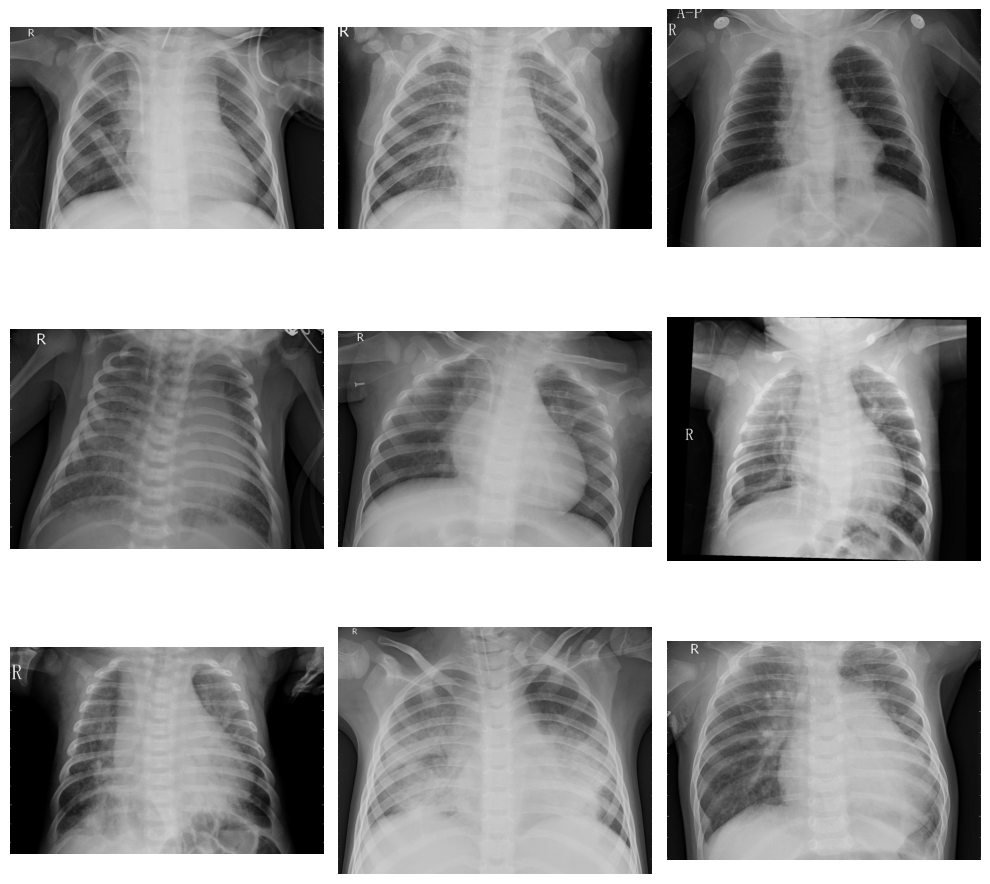

In [81]:
path_images = "data/ChestXray_pneumonia_prediction/PNEUMONIA/"

# Pick 9 random images
np.random.seed(1)
mask = metadata["folder"] == "PNEUMONIA"
random_images = np.random.choice(metadata[mask]["image"], 9)


# Adjust the size of your images
plt.figure(figsize=(10,10))

# Iterate and plot random images
for i, filename in enumerate(random_images):
    filename = filename
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(path_images, filename))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()    

Die Bilder liegen in Graustufen vor.

### 3. Prepare data for machine learning: 
- Separate data / labels
- Split into train ~70% / validation ~15% / test ~15%

In [82]:
from sklearn.model_selection import train_test_split

patient_ids = metadata['patient_id'].unique()

train_ids, test_ids = train_test_split(patient_ids, test_size=0.15, random_state=42)

train_data = metadata[metadata['patient_id'].isin(train_ids)]
test_data = metadata[metadata['patient_id'].isin(test_ids)]

train_ids, val_ids = train_test_split(train_ids, test_size=0.178, random_state=42)

train_data = metadata[metadata['patient_id'].isin(train_ids)]
val_data = metadata[metadata['patient_id'].isin(val_ids)]

print(f"Training set size: {train_data.shape}")
print(f"Validation set size: {val_data.shape}")
print(f"Test set size: {test_data.shape}")

Training set size: (4102, 9)
Validation set size: (878, 9)
Test set size: (876, 9)


Um Data Leakage zu vermeiden, werden die Daten nach uniquen Patienten IDs aufgeteilt. Diese werden anschließend aufgeteilt in train und test ids. Anhand dieser lassen sich die Train- und Testdaten aus den Metadaten auslesen, sodass nur einzigartige IDs in den entsprechenden Splits sind. Der Vorgang wird bei dem Val-Datenset wiederholt. Das Resultat ist, dass die Bilder eines Patienten nicht in Train, Val- und Testset aufgeteilt werden. 

In [83]:
for patient_id in train_data['patient_id']:
    assert patient_id not in val_data['patient_id'] # throw an error if patient_id is in val_data
    assert patient_id not in test_data['patient_id'] # throw an error if patient_id is in test_data

Hier wird überprüft ob mein train_test_split funktioniert hat. Es wird überprüft, ob die Patienten IDs in den Splits nicht doppelt vorkommen. Sollte das der Fall sein wird ein Fehler geworfen.

In [84]:
classes = ["none", "bacteria", "virus"]

In [85]:
print(train_data['label'].value_counts())
print(train_data[classes].sum().sort_values(ascending=False))

1    3030
0    1072
Name: label, dtype: int64
bacteria    1990
none        1072
virus       1040
dtype: int64


In [86]:
print(test_data['label'].value_counts())
print(test_data[classes].sum().sort_values(ascending=False))

1    613
0    263
Name: label, dtype: int64
bacteria    386
none        263
virus       227
dtype: int64


In [87]:
print(val_data['label'].value_counts())
print(val_data[classes].sum().sort_values(ascending=False))

1    630
0    248
Name: label, dtype: int64
bacteria    404
none        248
virus       226
dtype: int64


Der Bias hat sich durch das Aufteilen der Daten nicht stark verändert. Im Trainingsset haben wir fast 3 mal so viele Pneumonie-Bilder wie normale Bilder. Im Testset und Valset haben wir ca. 2.5 mal so viele Pneumonie-Bilder wie normale Bilder. 

### 4. Build an image generator pipeline
- Use keras `ImageDataGenerator` to define a `train_generator` and a `validation_generator`.
- Use the generator to recale the pixel values and to reshape the image to the desired format.

In [88]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images
image_generator = ImageDataGenerator(
    rescale=1.0/255 #rescale the image to be between 0 and 1 instead of 0 and 255, better for the neural network
)

# select the column with the labels
label_column = "label"

# Define the data generators
train_generator = image_generator.flow_from_dataframe(
        dataframe=train_data,
        x_col="image_path_and_filename", #x_col is the column with the filenames
        y_col=label_column,
        target_size=(320,320),
        batch_size=32, #how many images are loaded at once. 
        class_mode="raw", #raw because we have only one label column which is already encoded in 0 and 1
        color_mode="grayscale" #grayscale because we have grayscale images
)
val_generator = image_generator.flow_from_dataframe(
        dataframe=val_data,
        x_col="image_path_and_filename",
        y_col=label_column,
        target_size=(320,320),
        batch_size=32,
        class_mode="raw",
        color_mode="grayscale",
        shuffle = False) #im val dataset wollen wir nicht das er shuffelt sonst haben wir eine unterschiedliche Reihenfolge wenn wir auf val predicten

Found 4102 validated image filenames.
Found 878 validated image filenames.


Es wurden 2 Image Generatoren mit Keras erstellt, die die Bilder aus den jeweiligen Ordnern laden. Die Bilder werden in Graustufen geladen und auf eine Größe von 320x320 Pixeln skaliert. Die Pixelwerte werden auf einen Wertebereich von 0 bis 1 skaliert. Als Label wurde die Spalte `label` verwendet, sodass das Model später vorhersagen kann, ob man Pneumonia hat oder nicht. Der Shuffle im Validation Generator wurde ausgestellt, um die Reihenfolge der Bilder beizubehalten und so später leichter die Labels mit der Vorhersage vergleichen zu können.

#### Inspect the generators

In [89]:
batch = next(train_generator)

In [90]:
batch[1] #labels

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Die Labels liegen wie erwartet binär vor.

In [91]:
batch[0].shape #images

(32, 320, 320, 1)

In [92]:
first_image = batch[0][0]
first_image.min(), first_image.max()

(0.0, 1.0)

Die Bilder haben Pixelwerte zwischen 0 und 1.

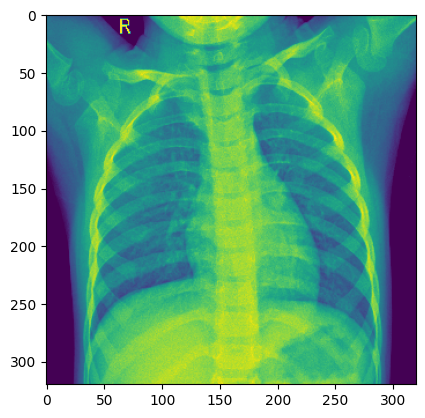

In [93]:
plt.imshow(first_image)

### 5. Train your own custom-made CNN (pneumonia yes/no prediction)
- Define a conventional CNN image classifier (convolution-pooling steps, followed by dense layers) to predict if a patient has pneumonia or not.

In [94]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from keras.models import Model

In [95]:
inputs = Input(shape=(320,320,1))

# Define CNN architecture
x = Conv2D(32, (3, 3))(inputs) # 32 filters, 3x3 kernel size
x = MaxPooling2D((2, 2))(x) # 2x2 max pooling, halbiert die Breite und Höhe des Bildes    
x = Conv2D(64, (3, 3))(x) # 64 filters, 3x3 kernel size
x = MaxPooling2D((2, 2))(x) 
x = Conv2D(128, (3, 3))(x) # 128 filters, 3x3 kernel size
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3))(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3))(x) # man erhöht die Anzahl der Filter damit man auch komplexere Muster erkennen kann. Kleinere Filter erkennen eher simple Muster (z.B. Verstärunkung vertikaler Konturen) 
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x) # Umwandlung in einen Vektor 
x = Dense(64, activation = "relu")(x) # 64 Neuronen im hidden layer mit Relu als Aktivierungsfunktion -> Negative Werte werden auf 0 gesetzt
outputs = Dense(1, activation = "sigmoid")(x) # sigmoid weil wir nur 2 Klassen haben -> Wert zwischen 0 und 1

# Create model
model = Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 318, 318, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 159, 159, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 78, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 76, 128)       73856 

In [96]:
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model.compile(optimizer='adam',
              loss="binary_crossentropy", #soll eine zahl zwischen 0 und 1 vorhersagen und ein punishment bekommen wenn er daneben liegt
              metrics=metrics)

Als Loss Funktion habe ich binary_crossentropy gewählt, da wir ein Label vorhersagen, das entweder 0 oder 1 beinhaltet.

In [97]:
import datetime
from keras.callbacks import CSVLogger
date = datetime.datetime.now().strftime("%Y%m%d-%Hh%Mmin")
filename = f"models/CNN_Pneumonia_{date}.hdf5"
csv_logger = CSVLogger(f'models/CNN_Pneumonia_{date}_training.log')

Ich habe einen uniquen Filename definiert, um später das beste Model abzuspeichern. Zusätzlich logge ich die History.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filename, save_best_only=True),
    csv_logger,
]

# Train the model, doing validation at the end of each epoch.
epochs = 15

model.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator,
          verbose=1,
          callbacks=callbacks)

### 6. Use transfer learning to train a CNN classifier (pneumonia yes/no prediction)

##### Um das DenseNet121 von Keras verwenden zu können, müssen wir die Bilder in RGB umwandeln. Das DenseNet kann nur mit Bildern, die 3 Farbkanälen haben, umgehen (input_shape=(320,320,3)). Im folgenden wird dafür erneut ein ImageDataGenerator verwendet, um die Bilder in RGB umzuwandeln.

In [99]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images
image_generator_rgb = ImageDataGenerator(
    rescale=1.0/255 #rescale the image to be between 0 and 1 instead of 0 and 255, better for the neural network
)

# select the column with the labels
label_column = "label"

# Define the data generators
train_generator_rgb = image_generator_rgb.flow_from_dataframe(
        dataframe=train_data,
        x_col="image_path_and_filename", #x_col is the column with the filenames
        y_col=label_column,
        target_size=(320,320),
        batch_size=32, #how many images are loaded at once. 
        class_mode="raw", #raw because we have only one label column which is already encoded in 0 and 1
        color_mode="rgb" #grayscale because we have grayscale images
)
val_generator_rgb = image_generator_rgb.flow_from_dataframe(
        dataframe=val_data,
        x_col="image_path_and_filename",
        y_col=label_column,
        target_size=(320,320),
        batch_size=32,
        class_mode="raw",
        color_mode="rgb",
        shuffle = False) #im val dataset wollen wir nicht das er shuffelt sonst haben wir eine unterschiedliche Reihenfolge wenn wir auf val predicten

Found 4102 validated image filenames.
Found 878 validated image filenames.


#### Überprüfung ob die Bilder nun in RGB vorliegen

In [100]:
batch = next(train_generator_rgb)

In [101]:
batch[1] #labels

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0])

In [102]:
batch[0].shape #images

(32, 320, 320, 3)

Die Bilder haben nun 3 Farbkanäle.

In [103]:
first_image = batch[0][0]
first_image.min(), first_image.max()

(0.0, 1.0)

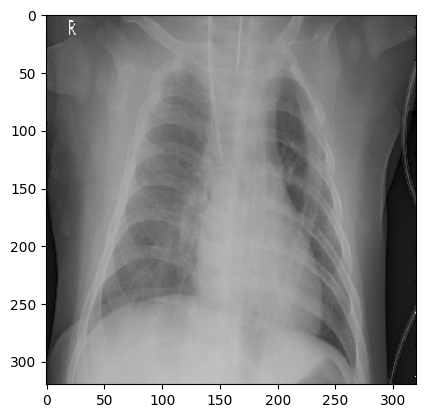

In [104]:
plt.imshow(first_image)

In [105]:
from tensorflow.keras.applications import DenseNet121

In [106]:
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(320,320,3))

Die letzten Dense Layer werden nicht mit übernommen, da diese auf die Anzahl der Klassen des ursprünglichen Datensets angepasst sind. Wir haben aber nur 2 Klassen.

In [107]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [108]:
from tensorflow.keras.layers import GlobalAveragePooling2D


x = base_model.output
x = GlobalAveragePooling2D()(x) #reduziert den letzten layer drastisch auf einen Wert pro Block(1024)
x = Dense(64, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)

model_with_dense_net = Model(inputs=base_model.input, outputs= output)
model_with_dense_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

                                                                                                  
 conv5_block16_1_bn (BatchNorma  (None, 10, 10, 128)  512        ['conv5_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_1_relu (Activati  (None, 10, 10, 128)  0          ['conv5_block16_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block16_2_conv (Conv2D)  (None, 10, 10, 32)   36864       ['conv5_block16_1_relu[0][0]']   
                                                                                                  
 conv5_block16_concat (Concaten  (None, 10, 10, 1024  0          ['conv5_block15_concat[0][0]',   
 ate)     

In [109]:
#wir wollen das net von keras nicht trainieren nur unseren letzten layer
for layer in base_model.layers:
    layer.trainable = False
    
model_with_dense_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

Wie man an den Trainable Parametern sieht, werden nur die letzten Dense Layer trainiert. Die Gewichte der Convolutional Layer werden nicht trainiert.

In [110]:
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model_with_dense_net.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=metrics)

In [ ]:
date = datetime.datetime.now().strftime("%Y%m%d-%Hh%Mmin")
filename = f"models/CNN_with_dense_net_Pneumonia_{date}.hdf5"
csv_logger = CSVLogger(f'models/CNN_with_dense_net_Pneumonia_{date}_training.log')
callbacks = [
    keras.callbacks.ModelCheckpoint(filename, save_best_only=True),
    csv_logger,
]

# Train the model, doing validation at the end of each epoch.
epochs = 15

model_with_dense_net.fit(train_generator_rgb,
          epochs=epochs,
          validation_data=val_generator_rgb,
          verbose=1,
          callbacks=callbacks)

Epoch 1/15
129/129 [==============================] - 564s 4s/step - loss: 0.2652 - accuracy: 0.8942 - precision: 0.9150 - recall: 0.9446 - val_loss: 0.1474 - val_accuracy: 0.9431 - val_precision: 0.9434 - val_recall: 0.9794
Epoch 2/15
129/129 [==============================] - 554s 4s/step - loss: 0.1540 - accuracy: 0.9456 - precision: 0.9624 - recall: 0.9640 - val_loss: 0.1141 - val_accuracy: 0.9601 - val_precision: 0.9598 - val_recall: 0.9857
Epoch 3/15
129/129 [==============================] - 577s 4s/step - loss: 0.1286 - accuracy: 0.9554 - precision: 0.9666 - recall: 0.9733 - val_loss: 0.1006 - val_accuracy: 0.9647 - val_precision: 0.9762 - val_recall: 0.9746
Epoch 4/15
129/129 [==============================] - 581s 5s/step - loss: 0.1253 - accuracy: 0.9517 - precision: 0.9637 - recall: 0.9713 - val_loss: 0.0965 - val_accuracy: 0.9636 - val_precision: 0.9731 - val_recall: 0.9762
Epoch 5/15
129/129 [==============================] - 579s 4s/step - loss: 0.1167 - accuracy: 0.9564

### 7. Evaluate both models
- Evaluate the models on data other than the training data.
- Plot a ROC curve and compute the area under the curve (AUC). What does this tell you?
- Compare to your custom-made CNN: which one achieves better results (and why)? Which one trains faster (and why)? What would you prefer to use in an actual medical application?

#### Eigenes CNN

In [112]:
#load model and predict
model = keras.models.load_model("models/CNN_Pneumonia_20230627-16h17min.hdf5")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 318, 318, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 159, 159, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 78, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 76, 76, 128)       7385

Da ich auf einem anderen Rechner trainiert habe, lade ich das Model erneut und führe die Evaluation durch.

In [115]:
test_generator = image_generator.flow_from_dataframe(
        dataframe=test_data,
        x_col="image_path_and_filename",
        y_col=label_column,
        target_size=(320,320),
        batch_size=32,
        class_mode="raw",
        color_mode="grayscale",
        shuffle = False) 

Found 876 validated image filenames.


In [127]:
y_pred = model.predict(test_generator)

28/28 [==============================] - 36s 1s/step


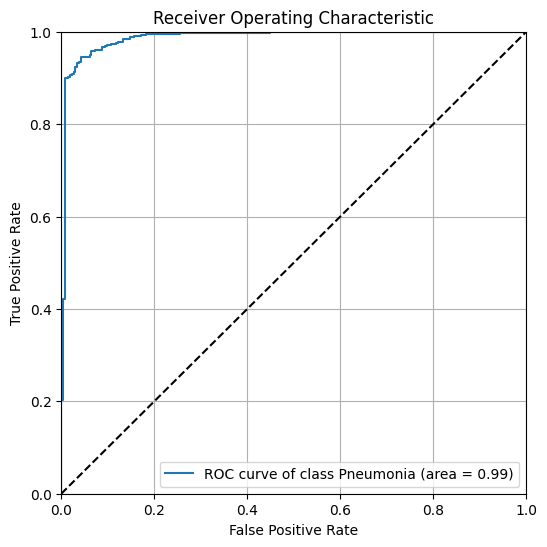

In [121]:
y_true = test_generator.labels
# Code for binary classification model

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(6, 6))

label = "Pneumonia"
#for i, label in enumerate(validation_generator.class_indices):
ax.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(label, roc_auc))

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()

Die ROC Curve dient zur Evaluierung der Model Performance. Sie stellt die Sensitivität/Recall (True Positive Rate) gegen die Spezifität/Precision (False Positive Rate) dar. Die AUC gibt an, wie gut das Model die Klassen unterscheiden kann. Eine AUC von ca. 0.99 bedeutet, dass das Model fast perfekt auf den Testdaten klassifiziert. Es gibt also nur sehr wenige False Positives und False Negatives Vorhersagen und das Model kann die Klassen vom Label sehr gut unterscheiden. Das das Modell so gut performt, liegt meiner Meinung auch an der Einfachheit der Klassifizierungsaufgabe. Es gibt nur 2 Klassen und die Bilder sind sehr unterschiedlich.

In [125]:
#load log file and print history
log = pd.read_csv("models/CNN_Pneumonia_20230627-16h17min_training.log")
log

,epoch,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0,0.907606,0.224021,0.930497,0.945545,0.912301,0.192476,0.927357,0.952381
1,1,0.922964,0.195759,0.941732,0.954785,0.919134,0.192991,0.942948,0.944444
2,2,0.927109,0.187275,0.944933,0.957096,0.933941,0.170750,0.934650,0.976190
3,3,0.938810,0.158841,0.954233,0.963366,0.943052,0.151067,0.948916,0.973016
4,4,0.946855,0.145730,0.958279,0.970297,0.939636,0.152093,0.935143,0.984127
5,5,0.948074,0.130094,0.961652,0.968317,0.951025,0.116676,0.959311,0.973016
6,6,0.947830,0.136353,0.962246,0.967327,0.952164,0.118060,0.953704,0.980952
7,7,0.958313,0.119070,0.970385,0.973267,0.956720,0.115919,0.977419,0.961905
8,8,0.967089,0.095681,0.974746,0.980858,0.949886,0.135144,0.942598,0.990476
9,9,0.966602,0.092895,0.974729,0.980198,0.962415,0.108870,0.973059,0.974603


Ich habe einen Callback beim Training eingebaut der mir nur das beste Model speichert. Wie gut ein Model ist wird dabei vom val_loss abhängig gemacht. Dieses Model wurde nach Epoch 11 gespeichert.

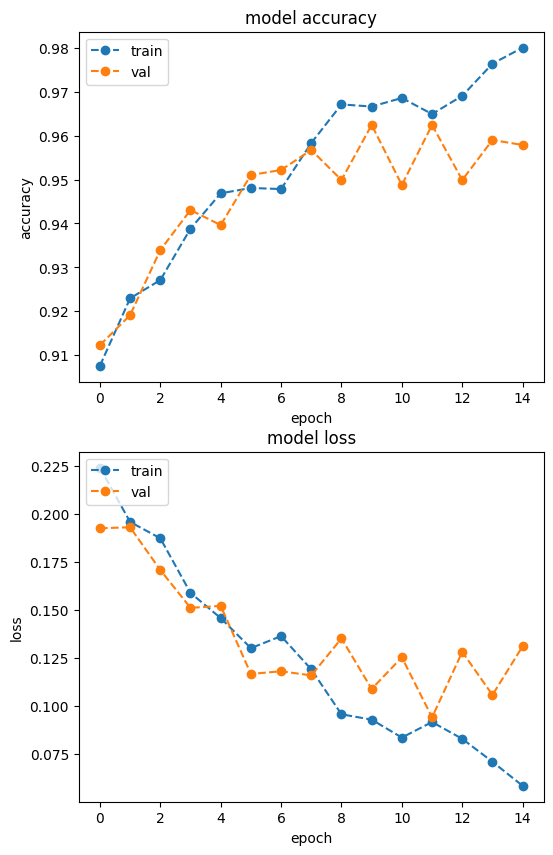

In [135]:
fix, (ax1, ax2) = plt.subplots(2, figsize=(6, 10))

# summarize history for accuracy
ax1.plot(log['accuracy'], "o--")
ax1.plot(log['val_accuracy'], "o--")
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# summarize history for loss
ax2.plot(log['loss'], "o--")
ax2.plot(log['val_loss'], "o--")
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

In diesem Plot erkennt man gut, dass der Val Loss stark anfängt zu schwanken ab Epoch 8.

#### CNN mit transfer learning (DenseNet121)

In [136]:
#load model and predict
model = keras.models.load_model("models/CNN_with_dense_net_Pneumonia_20230627-19h36min.hdf5")
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0          ['input_4[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [140]:
test_generator_rgb = image_generator.flow_from_dataframe(
        dataframe=test_data,
        x_col="image_path_and_filename",
        y_col=label_column,
        target_size=(320,320),
        batch_size=32,
        class_mode="raw",
        color_mode="rgb",
        shuffle = False) 

Found 876 validated image filenames.


In [141]:
y_pred = model.predict(test_generator_rgb)

28/28 [==============================] - 245s 9s/step


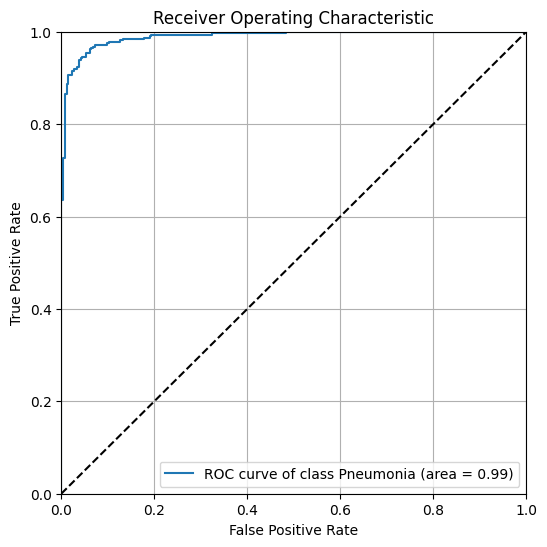

In [143]:
y_true = test_generator_rgb.labels
# Code for binary classification model

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(6, 6))

label = "Pneumonia"
#for i, label in enumerate(validation_generator.class_indices):
ax.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(label, roc_auc))

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()

Auch bei diesem Model leigt eine sehr gute AUC (0.99) vor. In der Performance liegen also sowohl das Model, welches mit transfer learning trainiert wurde, als auch das eigene CNN sehr nah beieinander.

In [144]:
#load log file and print history
log = pd.read_csv("models/CNN_with_dense_net_Pneumonia_20230627-19h36min_training.log")
log.sort_values(by="val_loss", ascending=True)

,epoch,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
10,10,0.964164,0.091802,0.972468,0.979208,0.964692,0.080541,0.970173,0.980952
11,11,0.967089,0.087561,0.977880,0.977558,0.965831,0.081572,0.970219,0.982540
14,14,0.970502,0.077410,0.976729,0.983498,0.968109,0.083068,0.980831,0.974603
12,12,0.967089,0.087988,0.974124,0.981518,0.970387,0.088415,0.982428,0.976190
4,4,0.956363,0.116742,0.969378,0.971617,0.970387,0.089816,0.973354,0.985714
3,3,0.951731,0.125307,0.963654,0.971287,0.963554,0.096473,0.973101,0.976190
2,2,0.955388,0.128560,0.966568,0.973267,0.964692,0.100556,0.976153,0.974603
7,7,0.961726,0.099650,0.972377,0.975908,0.960137,0.100699,0.985318,0.958730
1,1,0.945636,0.154027,0.962438,0.964026,0.960137,0.114063,0.959815,0.985714
8,8,0.963432,0.097454,0.973062,0.977558,0.953303,0.118512,0.942857,0.995238


Hier wurde das Model nach Epoch 10 gespeichert.

### Compare to your custom-made CNN: which one achieves better results (and why)? Which one trains faster (and why)? What would you prefer to use in an actual medical application?

#### Bessere Ergebnisse: 
Beide Modelle weisen auf den Testdaten eine AUC von 0.99 auf und liegen damit in der Performance sehr nah zusammen. Beide Modelle liefern in dieser Klassifizerungsaufgabe also gleiche Ergebnisse. Das Model mit transfer learning kann seinen Vorteil, dass es auf einem sehr großen Datenset trainiert wurde, noch nicht ausspielen. Ich gehe davon aus, dass sich das beim Multi-Class-Label (`infection_type`) ändern wird. Die Schwierigkeit der Klassifizierungsaufgabe war hier sehr gering, da es nur 2 Klassen gab und die Bilder sehr unterschiedlich waren.

#### Schnelleres Training: 
Obwohl die trainierbaren Parameter bei dem Transfer Learning Model geringer ausfallen, braucht es mehr Zeit das Model zu trainieren und auf Daten vorherzusagen, als bei dem eigenen Model. Das liegt vermutlich daran, dass die Bilder das komplette Model durchlaufen müssen, welches bei dem Transfer Learning Ansatz deutlich mehr Layer beinhaltet. Die trainierbaren Parameter spielen also nicht die entscheidende Rolle bei der Trainingszeit, sondern auch die Anzahl der Layer und ihre Größe, selbst wenn weniger Gewichte trainiert werden müssen.

#### What would you prefer to use in an actual medical application: 
Ich würde das Model wählen, das mit dem Transfer Learning Ansatz trainiert wurde. Durch das große Datenset auf dem das DenseNet121 trainiert wurde und seinen komplexeren Aufbau, kann es wahrscheinlich besser mit Ausreißern oder Röntgenbilder in schlechterer Qualität umgehen. Außerdem lässt es sich noch feintunen und kann einfacher auf andere Klassifizierungsaufgaben angewendet werden, selbst wenn man nur wenige Trainingsdaten hat.


### 8. Train a CNN for a multi-class prediction (bacteria, virus, none)
- Adapt a CNN (e.g. pick one form 5. or 6.) and modify it to predict if a patient has a bacterial or a virus infection, or none of both using the `infection_type` column as label.
- This requires to also adapt the generators.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images
image_generator = ImageDataGenerator(
    rescale=1.0/255 #rescale the image to be between 0 and 1 instead of 0 and 255, better for the neural network
)

# select the column with the labels
label_column = "infection_type"

# Define the data generators
train_generator = image_generator.flow_from_dataframe(
        dataframe=train_data,
        x_col="image_path_and_filename", #x_col is the column with the filenames
        y_col=label_column,
        target_size=(320,320),
        batch_size=32, #how many images are loaded at once. 
        class_mode="raw", #raw because we have only one label column which is already encoded in 0 and 1
        color_mode="grayscale" #grayscale because we have grayscale images
)
val_generator = image_generator.flow_from_dataframe(
        dataframe=val_data,
        x_col="image_path_and_filename",
        y_col=label_column,
        target_size=(320,320),
        batch_size=32,
        class_mode="raw",
        color_mode="grayscale",
        shuffle = False) #im val dataset wollen wir nicht das er shuffelt sonst haben wir eine unterschiedliche Reihenfolge wenn wir auf val predicten

Found 4102 validated image filenames.
Found 878 validated image filenames.


Dieses Mal wird als Label die Spalte `infection_type` verwendet. Diese Spalte beinhaltet die Werte `bacteria`, `virus` und `none`.

#### Inspect the generators

In [ ]:
batch = next(train_generator)

In [ ]:
batch[1] #labels

array([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Ändern siehe zeile unten

Die Labels liegen wie erwartet binär vor.

In [ ]:
batch[0].shape #images

(32, 320, 320, 1)

In [ ]:
first_image = batch[0][0]
first_image.min(), first_image.max()

(0.0, 1.0)

Die Bilder haben Pixelwerte zwischen 0 und 1.

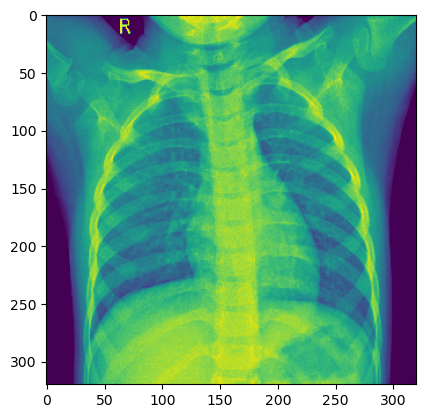

In [ ]:
plt.imshow(first_image)

In [ ]:
inputs = Input(shape=(320,320,1))

# Define CNN architecture
x = Conv2D(32, (3, 3))(inputs) # 32 filters, 3x3 kernel size
x = MaxPooling2D((2, 2))(x) # 2x2 max pooling, halbiert die Breite und Höhe des Bildes    
x = Conv2D(64, (3, 3))(x) # 64 filters, 3x3 kernel size
x = MaxPooling2D((2, 2))(x) 
x = Conv2D(128, (3, 3))(x) # 128 filters, 3x3 kernel size
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3))(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3))(x) # man erhöht die Anzahl der Filter damit man auch komplexere Muster erkennen kann. Kleinere Filter erkennen eher simple Muster (z.B. Verstärunkung vertikaler Konturen) 
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x) # Umwandlung in einen Vektor 
x = Dense(64, activation = "relu")(x) # 64 Neuronen im hidden layer mit Relu als Aktivierungsfunktion -> Negative Werte werden auf 0 gesetzt
outputs = Dense(1, activation = "sigmoid")(x) # sigmoid weil wir nur 2 Klassen haben -> Wert zwischen 0 und 1

# Create model
model = Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 318, 318, 32)      320       
                                                                 


 max_pooling2d (MaxPooling2D  (None, 159, 159, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 78, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 76, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 38, 38, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 36, 36, 128)       147584    
                                                                 
 max_pooli

In [ ]:
# Calculate class weights
class_weights = train_data[classes].sum(axis=0)
class_weights = class_weights.sum() / class_weights 

# Ensure class weights sum up to 1
class_weights = class_weights / class_weights.sum()
class_weights

none        0.389186
bacteria    0.209652
virus       0.401161
dtype: float64

Um den Bias in den Daten auszugleichen, habe ich Gewichtungen für jede Klasse berechnet.

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

def weighted_binary_crossentropy(class_weights):
    class_weights = tf.constant([class_weights[k] for k in sorted(class_weights.keys())], dtype=tf.float32)  # ensure class_weights is float32

    def _weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)  # ensure y_true is float32
        y_pred = tf.cast(y_pred, tf.float32)  # ensure y_pred is float32
        crossentropy = binary_crossentropy(y_true, y_pred)
        weight_vector = tf.reduce_sum(class_weights * y_true, axis=-1)
        weighted_loss = weight_vector * crossentropy
        return tf.reduce_mean(weighted_loss)

    return _weighted_binary_crossentropy


Diese Funktion erweitert die Loss Funktion Binary Crossentropy um die Gewichtungen. Die Gewichtungen werden als Parameter übergeben.

In [ ]:
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model.compile(optimizer ='adam',
              loss = weighted_binary_crossentropy(class_weights),
              metrics = metrics)

In [ ]:
import datetime
from keras.callbacks import CSVLogger
date = datetime.datetime.now().strftime("%Y%m%d-%Hh%Mmin")
filename = f"models/CNN_Pneumonia_{date}.hdf5"
csv_logger = CSVLogger(f'models/CNN_Pneumonia_{date}_training.log')

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filename, save_best_only=True),
    csv_logger,
]

# Train the model, doing validation at the end of each epoch.
epochs = 15

model.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator,
          verbose=1,
          callbacks=callbacks)

Epoch 1/15


KeyboardInterrupt: 